Below is my proposed lens-detection pipeline. I've written it as several functions and objects. 

###Residual Object
First thing's first is the Residual object. It holds all the information pertinent to a cluster that was identified in the image.

In [7]:
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
plt.xkcd()
from IPython.core.pylabtools import figsize
from sklearn.cluster import DBSCAN

class Residual(object):
    
    def __init__(self, pointsSet, key, image, color):
        
        self.pointsSet = pointsSet #a set of all points in tuples, for membership and accessing image pixels
        self.points = np.array(list(pointsSet)) #an np array of points.  
        
        self.key = key# the key to access the Residual in the dictionary, 'Noise' or 0,1,2...
        if self.key == -1:
            self.key = 'Noise'
        self.image = image # a reference to the image this object comes from
        self.color = color #the color to use in plotting, for consistency. 
        
        self.center, self.dist, self.vect, self.theta = self._findMoments() #find the center of this residual and it's distance from the center
        self.a, self.b = self.vect
        
        #NOTE can calcluate slope to center of image here
        
    def __contains__(self, item): #for if point in Residual checks
        return self.pointsSet.__contains__(item)
    
    def __iter__(self): #return the tuples in an iterator, so the values can be accessed in the image. 
        return self.pointsSet.__iter__()
      
    def getXY(self):#returns the x and y as separate arrays, for plotting
        return self.points[:,1], self.points[:,0]
    
    def _findMoments(self): #find the moments of the distribution
        Ix = Iy = Ixx = Iyy = Ixy = I = long(0)
        
        for idx in self.pointsSet:
            y,x = idx
            val = self.image[idx]
            I+=val
            Ix+=x*val
            Iy+=y*val
            Ixx+=x*x*val
            Iyy+=y*y*val
            Ixy+=x*y*val
            
        xmean = Ix/I
        ymean = Iy/I
              
        img_y, img_x = self.image.shape
        imgCenterY, imgCenterX = img_y/2.0, img_x/2.0
        
        #the distane of the center of the light from the center of the distribution
        dist = np.sqrt((xmean-imgCenterX)**2+(ymean-imgCenterY)**2)
        
        Uxx = Ixx/I-xmean**2
        Uyy = Iyy/I-ymean**2
        Uxy = Ixy/I-xmean*ymean
        
        theta = .5*np.arctan(2.0*Uxy/(Uxx-Uyy))
        
        lambda1 = .5*(Uxx+Uyy)+.5*np.sqrt(4*Uxy**2+(Uxx-Uyy)**2)
        lambda2 = .5*(Uxx+Uyy)-.5*np.sqrt(4*Uxy**2+(Uxx-Uyy)**2)
        
        return (ymean, xmean), dist, (np.sqrt(lambda1), np.sqrt(lambda2)), theta 
    
    def isNoise(self): #The clustering algorithm I'm using identifies noise clusters. 
        return self.key == 'Noise'

The function below takes a filename and loads in the numpy array. It creates a dictionary of Residual objects, of the clusters in the image. 

In [8]:
def makeResidualsDict(filename): #makes a dict of Residual objects from a filename
    
    image  = np.loadtxt(filename, delimiter = ',')
    std = image.std()
    mean = image.mean()
    nSigma = 1
    threshold = mean+nSigma*std #if there are pixels where the value is n std'
     
    #gather the x y data
    data = []
    img_y, img_x = image.shape
    for x in xrange(img_x):
        for y in xrange(img_y):
            if image[y,x]>threshold:
                data.append([y,x])
                
    data = np.array(data)
    
    #cluster the points
    agg = DBSCAN(eps = 2, min_samples = 6)

    agg.fit(data)
    labels = agg.labels_
    
    #gather the clusters into the dictionary
    nClusters = len(set(labels))
    clustRange = xrange(nClusters)
    if -1 in labels:
    #noise cluster identified
        clustRange = xrange(-1, nClusters-1)
    
    colors = ['r', 'b', 'g', 'm', 'c', 'y', 'k']
    residuals = {}
    for i, color in zip(clustRange, colors):
        #gather the points by cluster and create their cluster object. 
        cluster = set()
        d = data[labels == i]
    
        for idx in d:
            cluster.add(tuple(idx))
        
        #create the objects and put them in the dictionary
        if i == -1:
            residuals['Noise'] = Residual(cluster, 'Noise',image, color)
        else:
            residuals[i] =Residual(cluster, i, image, color)
            
    return residuals

###checkLens Pipeline
Below I work out the pipeline to determine if a residuals dictionary represents a lens or not. The pipeline's layout is as follows.

The first subdivision is by the number of objects identified. 

nObjects = 0: Not a lens, and nothing to check anyway

nObjects = 1: Possibly a lens. Possibly a complete "ring", or one stray arc. Test for both cases.

nObjects = 2: Multiple causes. Ideally, it'd be 2 objects on either side of one another from the lensed image. It's possible that they could be on the same side as one another, in which case check for comparable distance. Also check the perpendiculatiry of the axes.

nObjects >= 3: Similar to 2. Check if they are comparable distances from the center. Also, check that the major axes are all perpindicular to the line toward the center of the image. 

In [9]:
def checkLens(residuals):
    
    nObjects = len(residuals)
    if 'Noise' in residuals:
        nObjects -=1 #ignore noise
        
    if nObjects <1:
        return False 
    
    image = residuals[0].image
    
    if nObjects == 1:
        residual = residuals[0]
        center_difference = 3 #the distance from the center the ring is allowed to be. 
        if residual.dist<=center_difference:
            return True
        
        return False
            
    else: #nObjects >=2
        
        enoughPerp = False #enough of the objects have axes perpendicular to the line to the center
        closeTogether = False# the objects are a comparable distance from the center
        imgCy, imgCx = (image.shape[0]-1)/2.0, (image.shape[1]-1)/2.0
        
        objs = [residuals[i] for i in xrange(nObjects)]
        #the slope of the line connecting the center of the object to the center of the image.
        slopes = [(obj.center[0]-imgCy)/float(obj.center[1]-imgCx) for obj in objs]
        properlyOriented = 0
        for obj, slope in zip(objs, slopes):
            
            theta = -1*obj.theta #seems to come out negative; not sure if it's a plotting error or what. 
            axesSlope = 1/np.tan(theta)
            #maybe I should be specifically checking the major axis
            properlyOriented+= 1 if .1<abs(axesSlope/slope)<10 else 0 #comparable in magnitude
            
        enoughPerp = properlyOriented >1 #if there is more than one lined up well
        #the differences of the distances of the objects to their centers
        diffs = []
        for i, obj in enumerate(objs):
            for obj2 in objs[i+1:]:
                diffs.append(abs(obj.dist-obj2.dist))
                
        diffs = np.array(diffs)
        #if the average distance from one another is small
        closeTogether = diffs.mean()<3 #arbitrary number. 
        
        if nObjects == 2: #special case
            slope1, slope2 = slopes[0], slopes[1]
            ratio = slope1/slope2
            #i'm not sure if you want a positive slope or allow a slight negative difference, for a 'kink'
            
            #check if the objects are across the center from one another. 
            acrossOneAnother= ratio>-.2 and .1<abs(ratio)<10 #opposite sides and comparable slopes
            return (acrossOneAnother and enoughPerp) or (acrossOneAnother and closeTogether \
                        or enoughPerp and closeTogether)#any 2
        
        return closeTogether and enoughPerp

And last but not least, a plotting function to show the image, the clusters, and the axes/lines.

In [10]:
def plotResiduals(residuals): #plots all info for the residual. 
    image = residuals[0].image
    threshold = image.mean()+image.std()
    threshImage = np.where(image>threshold, image, 0) #cut out what was below threshold
    figsize(16,8)
    plt.subplot(121)
    plt.title('Caught Pixels')
    plt.imshow(threshImage)
    
    plt.subplot(122)   
    
    for residual in residuals.itervalues():
        img_y, img_x = image.shape
        plt.subplot(122)
        if residual.isNoise(): #don't plot noise
            continue
        
        s = []#list of sizes of the points in the scatter plot
        for idx in residual:
            val = (image[idx]-threshold)*15
            s.append(val)
        
        xx, yy = residual.getXY() 
        plt.scatter(xx, img_y-yy, color = residual.color, s = s)
        
        plt.subplot(121)
        plt.xlim(0,img_x )
        plt.ylim(img_y, 0)
        yc, xc = residual.center
        a, b = residual.a, residual.b
        #Theta seems to be coming out wrong. I don't know if it's the plot being weird or what. 
        theta = -1*residual.theta
        
        plt.scatter(xc, yc, color = 'k')
        plt.plot((xc - a * np.sin(theta), xc + a * np.sin(theta)), \
                   (yc - a * np.cos(theta), yc + a * np.cos(theta)), color='g', linewidth = 2)
    
        plt.plot((xc - b * np.cos(theta), xc + b * np.cos(theta)), \
                  (yc + b * np.sin(theta), yc - b * np.sin(theta)), color='m', linewidth =2)
        imgCx, imgCy = (img_x-1)/2.0, (img_y-1)/2.0
        plt.plot((xc, imgCx), (yc, imgCy), color = 'r', linewidth = 2)
       
    plt.subplot(122)  
    plt.xlim(0, img_x)
    plt.ylim(0, img_y)
    plt.title('Identified Clusters')
    plt.show()

###Run on 12 objects

Now I'll run these functions on a directory of objects.

CFHTLS_047_0155 was identified as a lens.


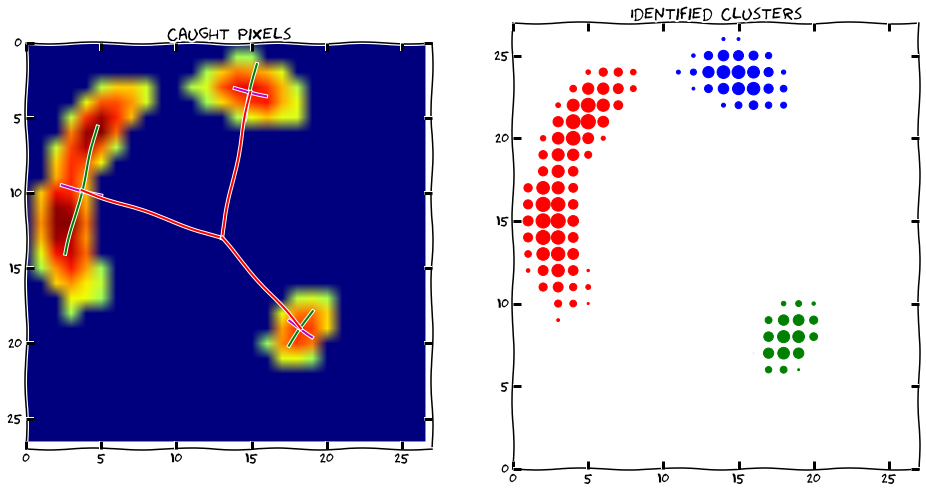

----------------------------------------------------------------------------------------------------


CFHTLS_047_1845 was identified as a lens.


/home/jeffrey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in double_scalars


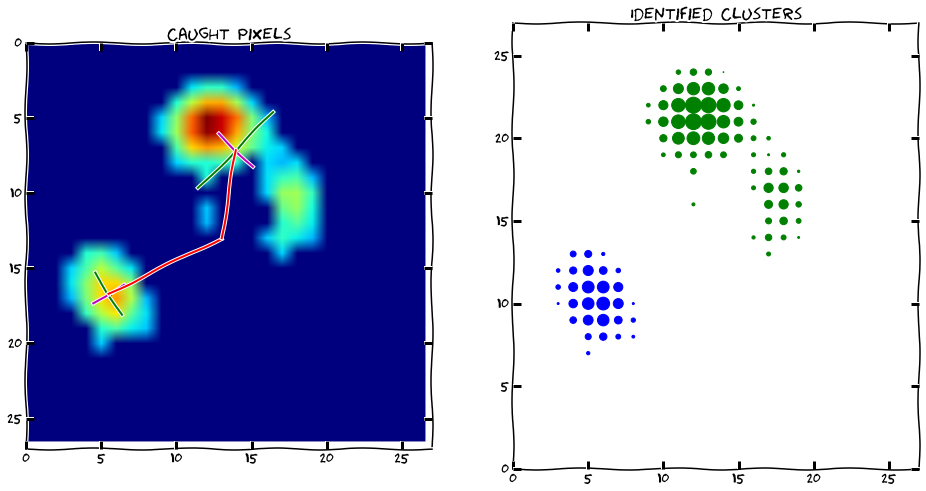

----------------------------------------------------------------------------------------------------


CFHTLS_047_0790 was identified as a lens.


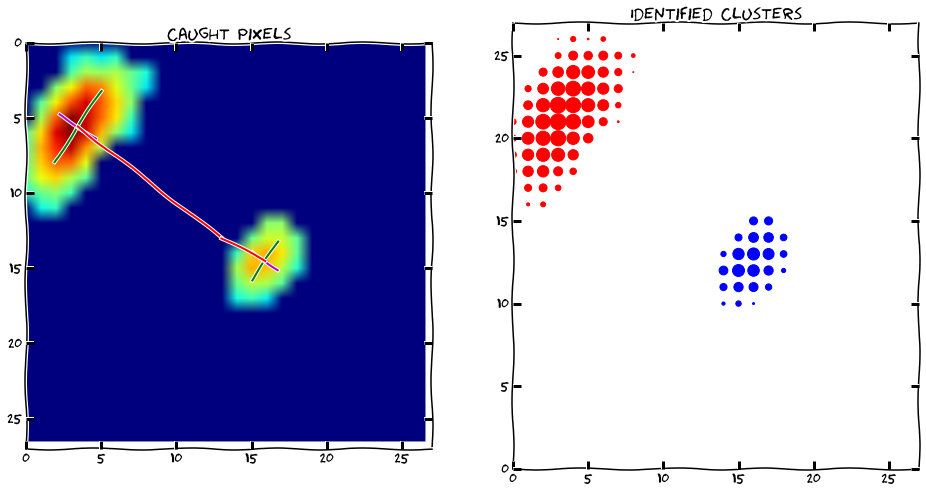

----------------------------------------------------------------------------------------------------


CFHTLS_047_1846 was NOT identified as a lens.


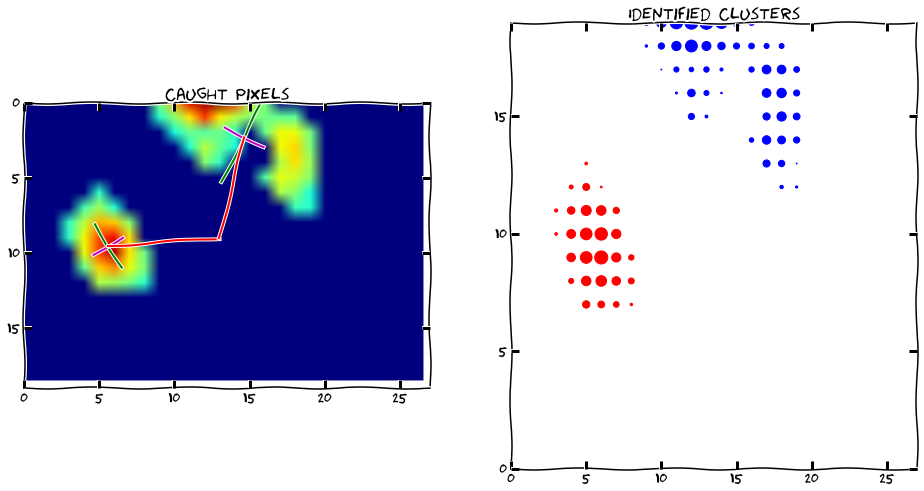

----------------------------------------------------------------------------------------------------


CFHTLS_072_2003 was identified as a lens.


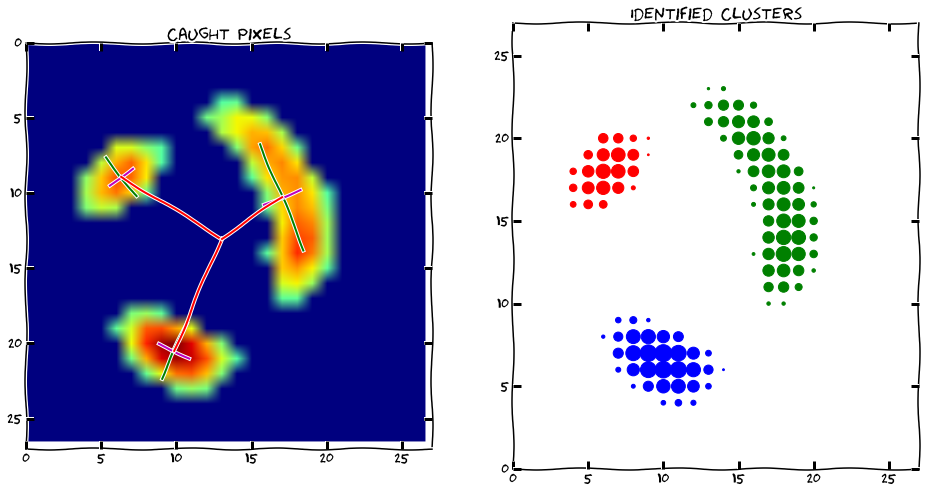

----------------------------------------------------------------------------------------------------


CFHTLS_047_0855 was identified as a lens.


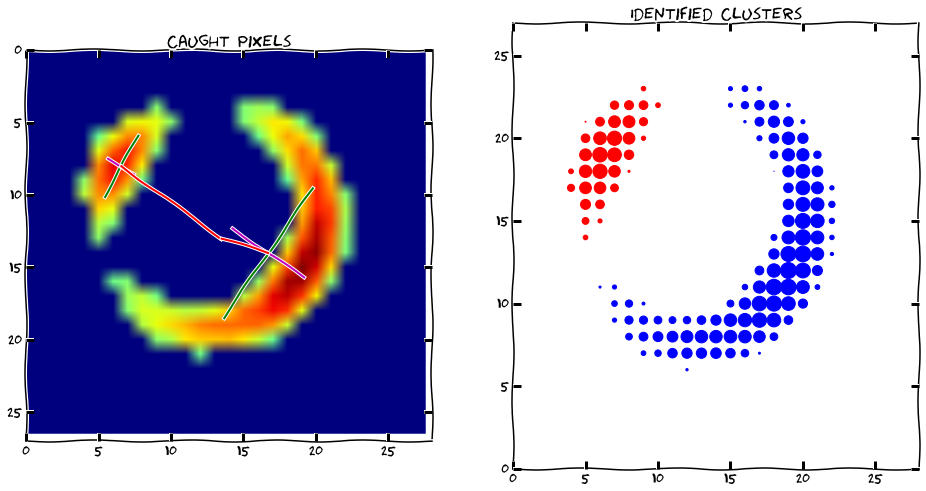

----------------------------------------------------------------------------------------------------


CFHTLS_047_1014 was identified as a lens.


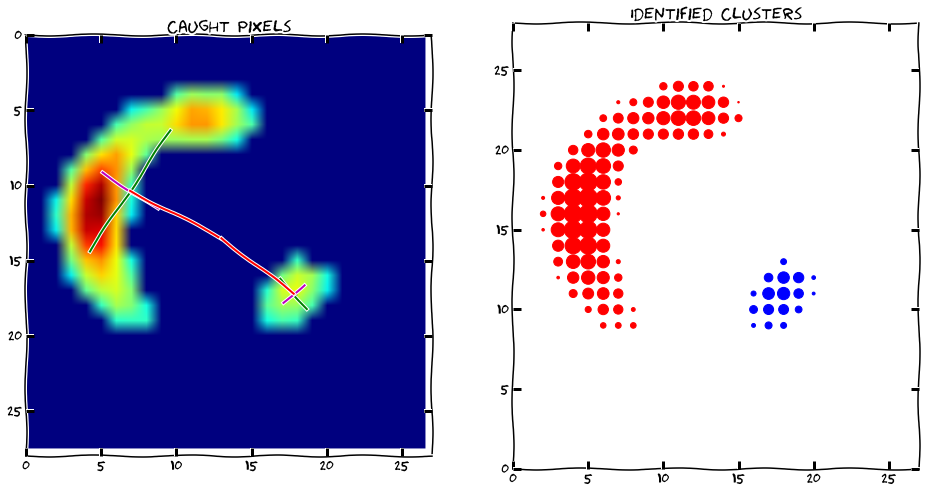

----------------------------------------------------------------------------------------------------


CFHTLS_047_1866 was identified as a lens.


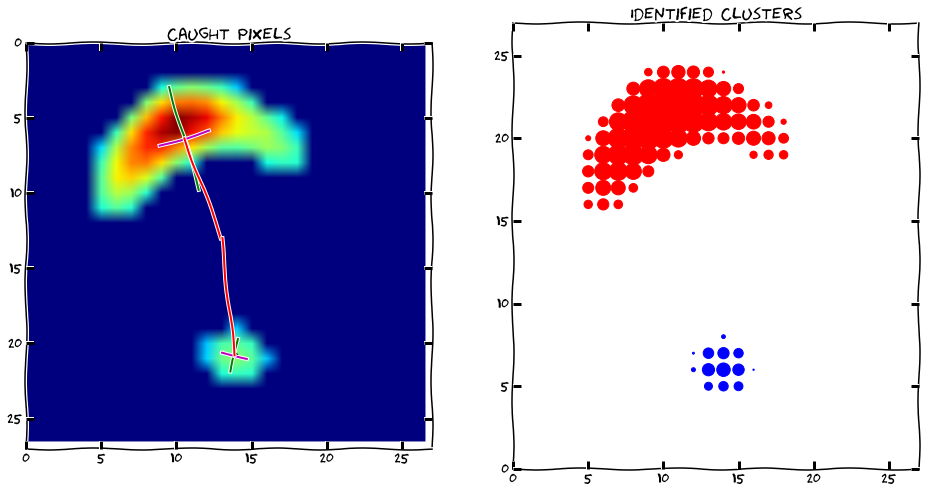

----------------------------------------------------------------------------------------------------


CFHTLS_047_0118 was NOT identified as a lens.


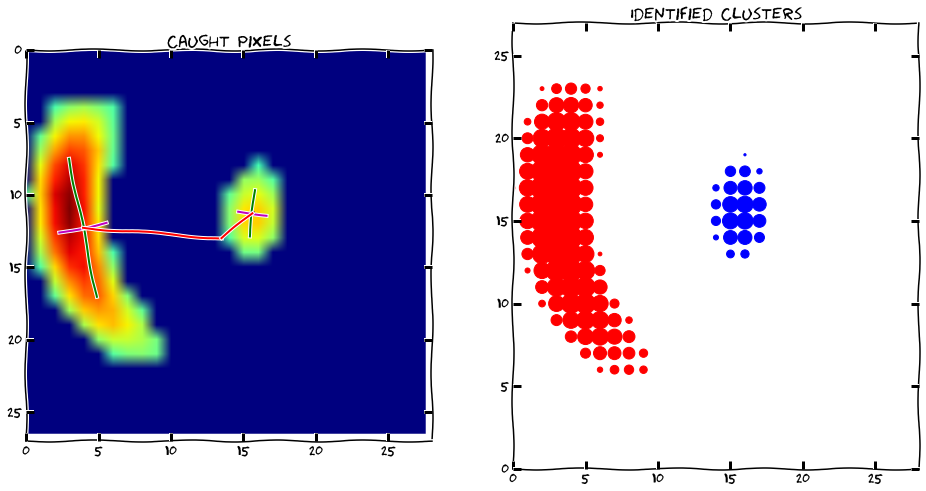

----------------------------------------------------------------------------------------------------


CFHTLS_047_1988 was NOT identified as a lens.


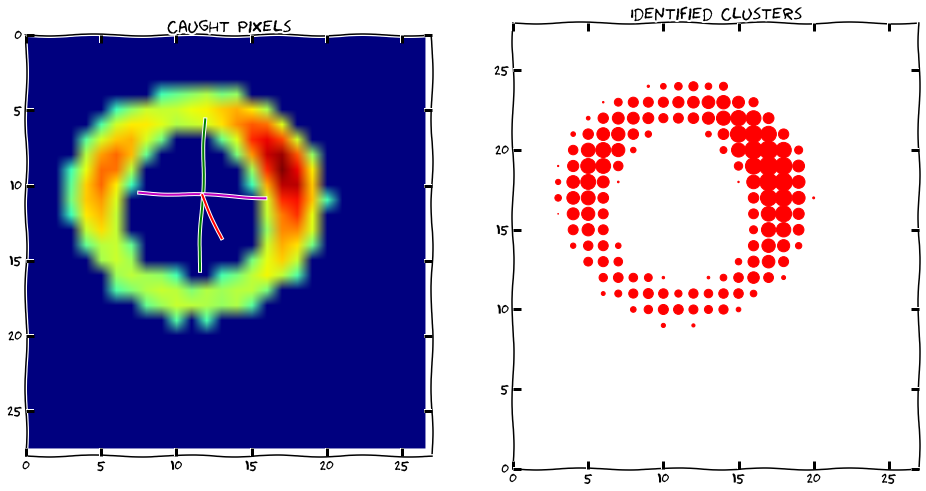

----------------------------------------------------------------------------------------------------


CFHTLS_047_0987 was identified as a lens.


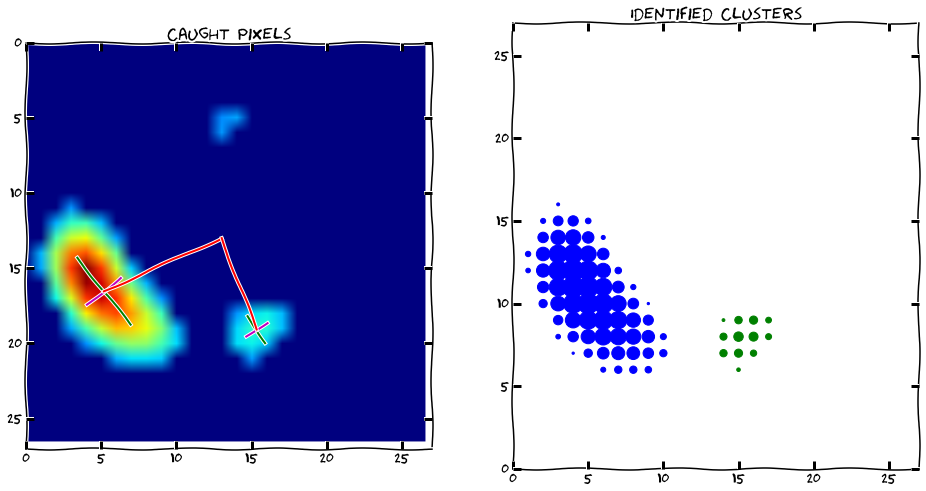

----------------------------------------------------------------------------------------------------


CFHTLS_047_0988 was identified as a lens.


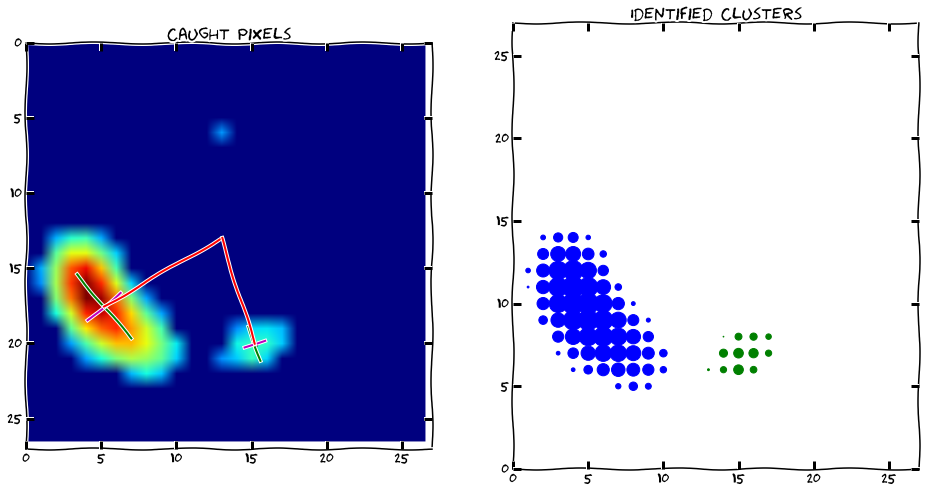

----------------------------------------------------------------------------------------------------




In [11]:
#make sure to change this directory name on your machine.
directory = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/residualArrays/'
filenames =os.listdir(directory)

for filename in filenames:
    residuals = makeResidualsDict(directory+filename)
    if checkLens(residuals):
        print '%s was identified as a lens.'%filename
    else:
        print '%s was NOT identified as a lens.'%filename
    plotResiduals(residuals)
    print '-'*100+'\n\n'

3/12 faild to detect the lens. Not bad, but not great. I think the first 2 failed because the center was not properly identified in the image, because the center of the structure in those cases is not necessarily the center of the image. The last one fails becasue the distance from the center is 3.8, when the threshold is 3. I arbitrarily chose that threshold, so I could increase it.